In [32]:
import os
import json
for file in os.listdir("./imageLabel/."):
    if(file.endswith(")")):
        #data = json.loads(open('./imageLabel/' + file + "/data_file.json").read())
        if os.path.isfile('./imageLabel/' + file + "/data_file.json"):
            data = json.loads(open('./imageLabel/' + file + "/data_file.json").read())
            #data["folder_location"] = os.getcwd() + '/imageLabel/' + file
            data["folder_location"] = '/Users/lechn/Desktop/jasonTab/' + file
            data["image_location"] = '/Users/lechn/Desktop/East Team S2 2/' + file + ".jpg"
            with open('./imageLabel/' + file + "/data_file.json", "w") as write_file:
                json.dump(data, write_file)

In [1]:
import pandas as pd
import tensorflow as tf
import sys
print(sys.version)
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy
from ipywidgets import interact, widgets
from scipy import stats
import seaborn as sns
import os
import json
from pprint import pprint
import cv2

3.6.5 (default, Jun 17 2018, 12:13:06) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]


Using TensorFlow backend.


In [4]:
numGrids = 12
features = []
y = []
for file in os.listdir("./imageLabel/."):
    if(file.endswith(")")):
        print("Extracting labels from file " + file)
        img = cv2.imread("../../East Team S2 2/" + file + ".jpg")
        height, width, channels = img.shape
        gheight, gwidth = int(height/numGrids) , int(width/numGrids)
        for index in range(numGrids**2):
            rowIndex = index % numGrids
            colIndex = int(index / numGrids)
            grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth, :]
            blur = cv2.resize(img, (256, 256))

            #feature extraction
            featureList = []
            gridRed = grid[:,:,0]
            gridGreen = grid[:,:,1]
            gridBlue = grid[:,:,2]
            rbar = np.average(gridRed)
            gbar = np.average(gridGreen)
            bbar = np.average(gridBlue)
            featureList.append(rbar)
            featureList.append(gbar)
            featureList.append(bbar)
            featureList += np.bincount(np.ravel((gridRed/32).astype(int)), minlength = 8).tolist()
            featureList += np.bincount(np.ravel((gridGreen/32).astype(int)), minlength = 8).tolist()
            featureList += np.bincount(np.ravel((gridBlue/32).astype(int)), minlength = 8).tolist()

            features.append(featureList)
                    
                    
                    

Extracting labels from file A (108)
Extracting labels from file A (141)
Extracting labels from file A (243)
Extracting labels from file A (187)
Extracting labels from file A (225)
Extracting labels from file A (30)
Extracting labels from file A (127)
Extracting labels from file A (164)
Extracting labels from file A (15)
Extracting labels from file A (249)
Extracting labels from file A (200)
Extracting labels from file A (102)
Extracting labels from file A (209)
Extracting labels from file A (240)
Extracting labels from file A (184)
Extracting labels from file A (142)
Extracting labels from file A (124)
Extracting labels from file A (9)
Extracting labels from file A (226)
Extracting labels from file A (33)
Extracting labels from file A (39)
Extracting labels from file A (3)
Extracting labels from file A (167)
Extracting labels from file A (148)
Extracting labels from file A (101)
Extracting labels from file A (16)
Extracting labels from file A (203)
Extracting labels from file A (237)
E

In [39]:
features = np.asarray(features)
features = features / features.max(axis=0)
print("Features shape", features.shape)

Features shape (29376, 27)


In [35]:
from keras.models import load_model
model = load_model('model.h5py')

In [40]:
features.shape

(29376, 27)

In [41]:
k = model.predict_classes(features)

In [48]:
jobs = list(set(k))
counts = [list(k).count(job) for job in jobs]
print(jobs)
print(counts)

[1, 3, 4, 5, 6, 8, 9]
[25823, 3340, 44, 30, 137, 1, 1]


In [60]:
import pickle
pickle_in = open("dict.pickle","rb")
reverseDic = pickle.load(pickle_in)
if jobs[0] in reverseDic:
    jobs = [reverseDic[job] for job in jobs]

Text(0.5, 1.0, 'Number of Labels for Each Waste Type')

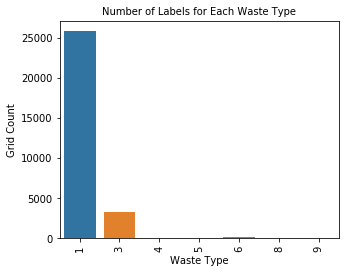

In [49]:
f, ax = plt.subplots(figsize=(5, 4))
plt.xticks(rotation='90')
sns.barplot(x=jobs, y=counts)
plt.xlabel('Waste Type', fontsize=10)
plt.ylabel('Grid Count', fontsize=10)
plt.title('Number of Labels for Each Waste Type', fontsize=10)